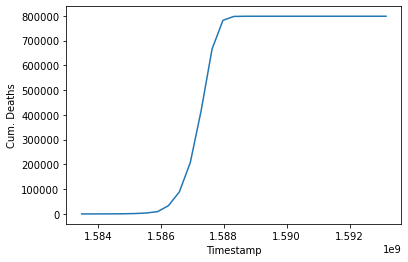

In [3]:
import logging
import pandas as pd
import datetime
import seaborn as sb
import time
from ipywidgets import interact, fixed

from libs.CovidTimeseriesModel import CovidTimeseriesModel
from libs.CovidDatasets import CovidDatasets

## Constants
start_time = time.time()
COVID_DATASETS=CovidDatasets()
MODEL = CovidTimeseriesModel()
HOSPITALIZATION_RATE = .073
HOSPITALIZED_CASES_REQUIRING_ICU_CARE = .1397
MODEL_INTERVAL = 4
TOTAL_INFECTED_PERIOD = 12  # In days
# Pack all of the assumptions and parameters into a dict that can be passed into the model
MODEL_PARAMETERS = {
    # Pack the changeable model parameters
    'timeseries': COVID_DATASETS.get_timeseries_by_country_state('USA', 'CA'),
    'beds': COVID_DATASETS.get_beds_by_country_state('USA', 'CA'),
    'population': COVID_DATASETS.get_population_by_country_state('USA', 'CA'),
    'projection_iterations': 25,
    'r0': 2.4,
    'hospitalization_rate': HOSPITALIZATION_RATE,
    'initial_hospitalization_rate': .05,
    'case_fatality_rate': .011,
    'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
    # Assumes that anyone who needs ICU care and doesn't get it dies
    'case_fatality_rate_hospitals_overwhelmed': HOSPITALIZATION_RATE * HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
    'hospital_capacity_change_daily_rate': 1.05,
    'max_hospital_capacity_factor': 2.07,
    'initial_hospital_bed_utilization': .6,
    'model_interval': MODEL_INTERVAL,
    'total_infected_period': TOTAL_INFECTED_PERIOD,
    'rolling_intervals_for_current_infected': int(round(TOTAL_INFECTED_PERIOD / MODEL_INTERVAL, 0)),
}

def run_model(model_parameters):    
    return MODEL.forecast_region(model_parameters)

ak = run_model(model_parameters=MODEL_PARAMETERS)

sb.lineplot(x='Timestamp', y='Cum. Deaths', data=ak)